In [52]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import re
from unidecode import unidecode
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 

def normalize_column_name(col):
    col = re.sub('(\n|\t)', '', col) # replace \n and \t with ''
    col = col.lower() # lower
    col = re.sub(' ', '_', col) # repace ' ' with '_'
    col = re.sub('-', '_', col) # repace ' ' with '_'
    col = unidecode(col) # remove accent
    return col

def del_column(df, col_list):
    rem = [i for i in df.columns if i not in col_list]
    df = df[rem]
    return df

# 1. Load & Cleaning data

In [53]:
l = pd.read_html('https://en.wikipedia.org/wiki/List_of_English_football_champions')
df = l[2]
df.columns = [normalize_column_name(i[0]) for i in df.columns]

df = (
    df
    .rename({'champions_(number_of_titles)': 'champion'}, axis = 1)
    .loc[:,['season', 'champion', 'runners_up', 'third_place']]
)

df = df[~ ((df['champion'].str.contains('War')) | (df['season'].str.contains(r'\('))) ]

df = (
    df
    .assign(champion =              lambda df_: df_['champion'].str.extract(r'(^[\w\s]+)')[0].str.strip())
    .assign(runners_up =            lambda df_: df_['runners_up'].str.extract(r'(^[\w\s]+)')[0].str.strip())
    .replace('The Wednesday', 'Sheffield Wednesday')
)
df

,season,champion,runners_up,third_place
0,1888–89,Preston North End,Aston Villa,Wolverhampton Wanderers
1,1889–90,Preston North End,Everton,Blackburn Rovers
2,1890–91,Everton,Preston North End,Notts County
3,1891–92,Sunderland,Preston North End,Bolton Wanderers
5,1892–93,Sunderland,Preston North End,Everton
...,...,...,...,...
125,2020–21,Manchester City,Manchester United,Liverpool
126,2021–22,Manchester City,Liverpool,Chelsea
127,2022–23,Manchester City,Arsenal,Manchester United
128,2023–24,Manchester City,Arsenal,Liverpool


# 2. Pre-processing

In [54]:
def add_season_year(df):
    df = (
        df
        .assign(season_start =          lambda df_: df_.season.apply(lambda x: int(x[:4])))
        .assign(season_end =            lambda df_: df_.season_start + 1)
        .sort_values(by = ['champion', 'season_end'], ignore_index=True)
        .assign(next_win =              lambda df_: df_.groupby('champion')['season_end'].shift(-1))
        .assign(gap =                   lambda df_: df_['next_win'] - df_['season_end'])
    )

    return df

df = add_season_year(df)
df

,season,champion,runners_up,third_place,season_start,season_end,next_win,gap
0,1930–31,Arsenal,Aston Villa,Sheffield Wednesday,1930,1931,1933.0,2.0
1,1932–33,Arsenal,Aston Villa,Sheffield Wednesday,1932,1933,1934.0,1.0
2,1933–34,Arsenal,Huddersfield Town,Tottenham Hotspur,1933,1934,1935.0,1.0
3,1934–35,Arsenal,Sunderland,Sheffield Wednesday,1934,1935,1938.0,3.0
4,1937–38,Arsenal,Wolverhampton Wanderers,Preston North End,1937,1938,1948.0,10.0
...,...,...,...,...,...,...,...,...
121,1960–61,Tottenham Hotspur,Sheffield Wednesday,Wolverhampton Wanderers,1960,1961,NaN,NaN
122,1919–20,West Bromwich Albion,Burnley,Chelsea,1919,1920,NaN,NaN
123,1953–54,Wolverhampton Wanderers,West Bromwich Albion,Huddersfield Town,1953,1954,1958.0,4.0
124,1957–58,Wolverhampton Wanderers,Preston North End,Tottenham Hotspur,1957,1958,1959.0,1.0


### 2.1. Detect and label the consecutive titles

In [55]:
def detect_label_consecutive(df):
    df = df.sort_values('season_end').reset_index(drop=True)
    df['lientiep_group'] = (df.season_end.diff() != 1).cumsum()

    df['lientiep_label'] = (
        df.lientiep_group
        .map(df.groupby('lientiep_group')
        .season_end.count()).apply(lambda x: str(x) + ' consecutive titles' if x > 1 else '')
    )
    
    return df.drop(columns= ['lientiep_group'])

def add_label_consecutive(df):
    df = df.groupby('champion', group_keys=False).apply(detect_label_consecutive).sort_values(by = 'season', ignore_index= True)
    return df

df = add_label_consecutive(df)
df

C:\Users\minhtl3\AppData\Local\Temp\ipykernel_16656\1305747927.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('champion', group_keys=False).apply(detect_label_consecutive).sort_values(by = 'season', ignore_index= True)


,season,champion,runners_up,third_place,season_start,season_end,next_win,gap,lientiep_label
0,1888–89,Preston North End,Aston Villa,Wolverhampton Wanderers,1888,1889,1890.0,1.0,2 consecutive titles
1,1889–90,Preston North End,Everton,Blackburn Rovers,1889,1890,NaN,NaN,2 consecutive titles
2,1890–91,Everton,Preston North End,Notts County,1890,1891,1915.0,24.0,
3,1891–92,Sunderland,Preston North End,Bolton Wanderers,1891,1892,1893.0,1.0,2 consecutive titles
4,1892–93,Sunderland,Preston North End,Everton,1892,1893,1895.0,2.0,2 consecutive titles
...,...,...,...,...,...,...,...,...,...
121,2020–21,Manchester City,Manchester United,Liverpool,2020,2021,2022.0,1.0,4 consecutive titles
122,2021–22,Manchester City,Liverpool,Chelsea,2021,2022,2023.0,1.0,4 consecutive titles
123,2022–23,Manchester City,Arsenal,Manchester United,2022,2023,2024.0,1.0,4 consecutive titles
124,2023–24,Manchester City,Arsenal,Liverpool,2023,2024,NaN,NaN,4 consecutive titles


### 2.2. Detect and label the largest gap between titles of a team

In [56]:
# largest_gap = df[df.gap > 1].groupby('champion')['gap'].max()
# df['largest_gap'] = df.apply(lambda row: "largest_gap" if row['gap'] == largest_gap.get(row['champion'], -1) else "", axis = 1)
# largest_gap_df = df[df.largest_gap == 'largest_gap'].drop_duplicates(subset='champion', keep='last')

In [57]:
# largest_gap
def detect_largest_gap(df):
    largest_gap = df[df.gap > 1].groupby('champion').gap.max()
    df['largest_gap'] = df.apply(lambda df_: "largest_gap" if df_['gap'] == largest_gap.get(df_['champion'], -1) else "", axis=1)
    largest_gap_df = df[df.largest_gap == 'largest_gap'].drop_duplicates(subset = 'champion', keep='last')
    
    return largest_gap_df

# 3. Analysis

### **Who were the winners?**

In [58]:
df.champion.nunique()

24

### **Who got the most titles?**

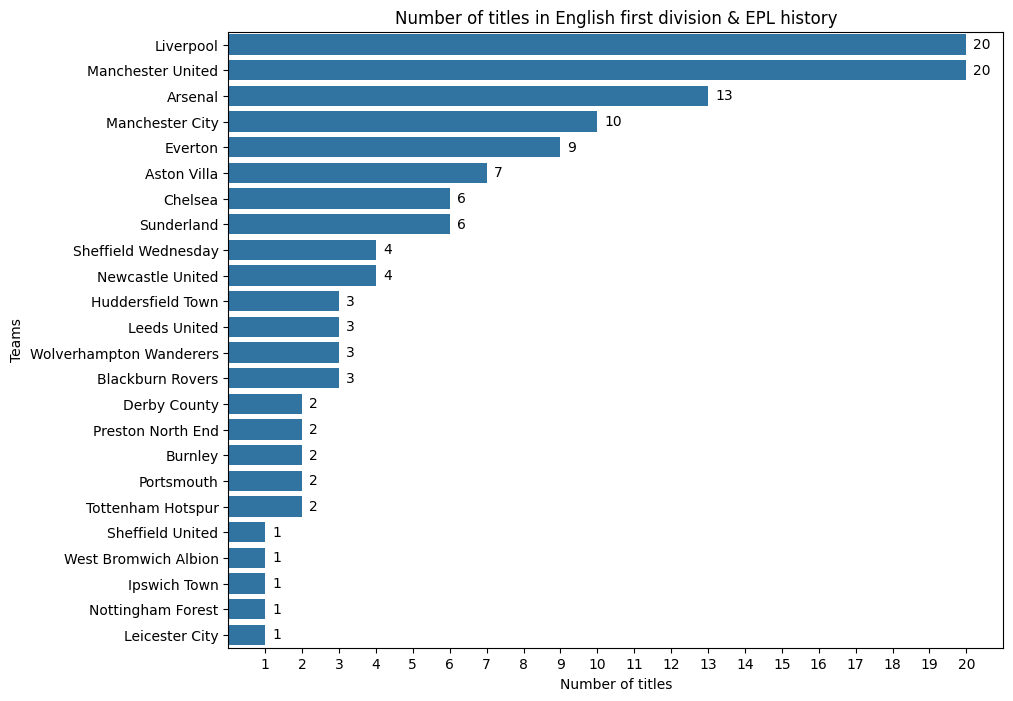

In [59]:
def visualize_number_of_titles(df):
    fig, ax = plt.subplots(figsize = (10,8))

    champion_value_count = df.champion.value_counts()
    num_champion = len(champion_value_count)

    barplot = sns.barplot(
        champion_value_count
        ,orient= 'h'
        ,ax=ax
    )

    ax.set_title('Number of titles in English first division & EPL history')
    ax.set_ylabel('Teams')
    ax.set_xlabel('Number of titles')
    plt.xticks(range(1,champion_value_count.max()+1))

    for bar in barplot.containers:
        ax.bar_label(bar, padding = 5, label_type= "edge")
        ax.bar

    plt.show()

visualize_number_of_titles(df)

### **When did they get the titles?**

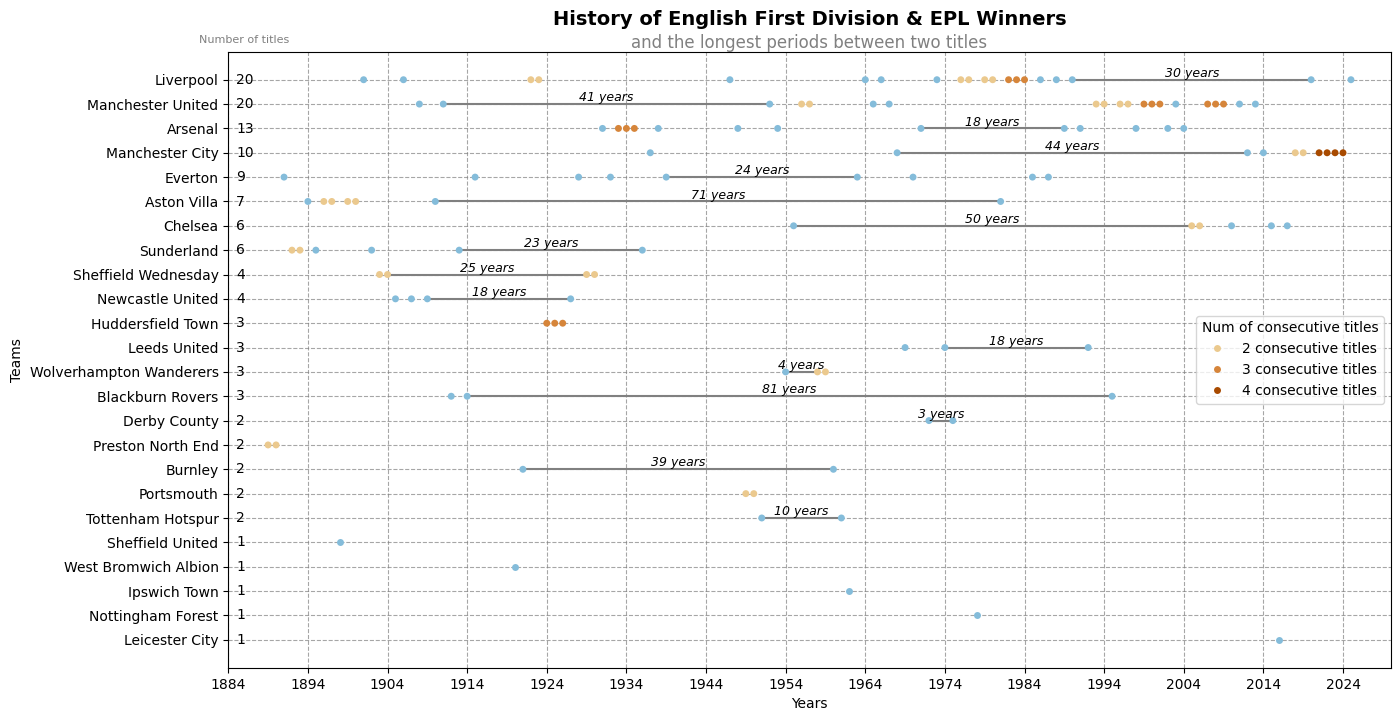

In [76]:
def titles_timeline(df):
    largest_gap_df = detect_largest_gap(df)
    fig, ax = plt.subplots(figsize = (15,8))
    min_x = df.season_end.min() - 5
    max_x = df.season_end.max() + 5

    champion_value_count = df.champion.value_counts()

    lientiep_color_dict = {
        '5 consecutive titles': '#604E3A'
        ,'4 consecutive titles': '#A84A00'
        ,'3 consecutive titles': '#D6853A'
        ,'2 consecutive titles': '#EBC98E'
        ,'': '#84BCDA'
    }

    df['lientiep_color'] = df.lientiep_label.map(lientiep_color_dict)

    sns.stripplot(
        data = df
        ,x = 'season_end'
        ,y = 'champion'
        ,jitter=False
        ,order= champion_value_count.index
        ,ax=ax
        ,hue= 'lientiep_label'
        ,palette= lientiep_color_dict
    )

    for i, (index, row) in enumerate(largest_gap_df.iterrows()):
        plt.plot([row['season_end'], row['next_win']], [row['champion'], row['champion']], color = 'grey')
        plt.text(
            x = (row['season_end'] + row['next_win'])/2
            , y = row['champion'], s = str(int(row['gap'])) + ' years'
            , fontsize = 9
            , ha = 'center'
            , va = 'bottom'
            , style = 'italic'
        )

    ax.legend(title = 'Num of consecutive titles')
    ax.set_title('History of English First Division & EPL Winners', fontweight = 'bold', fontsize = 14, y = 1.03)
    ax.text(0.5, 1, "and the longest periods between two titles",
            ha="center", va="bottom", transform=ax.transAxes, fontsize=12, color="gray")

    ax.set_xlabel('Years')
    ax.set_ylabel('Teams')
    ax.set_xlim((min_x, max_x))
    ax.set_xticks(range(min_x, max_x, 10))

    plt.grid(axis="y", color="grey", linestyle="--", alpha=0.7)
    plt.grid(axis="x", color="grey", linestyle="--", alpha=0.7)

    for i, val in enumerate(champion_value_count):
        plt.text(x = min_x+1, y = champion_value_count.index[i], s = str(val), va = 'center')

    ax.annotate(
        arrowprops=dict(arrowstyle = "->")
        ,text = ""
        ,xy = (1,1)
    )

    plt.text(min_x + 2, y = -1.5, s = "Number of titles", ha = "center", fontsize = 8, color = "gray")

    plt.show()

titles_timeline(df)

# 4. Main function

C:\Users\minhtl3\AppData\Local\Temp\ipykernel_16656\1305747927.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('champion', group_keys=False).apply(detect_label_consecutive).sort_values(by = 'season', ignore_index= True)


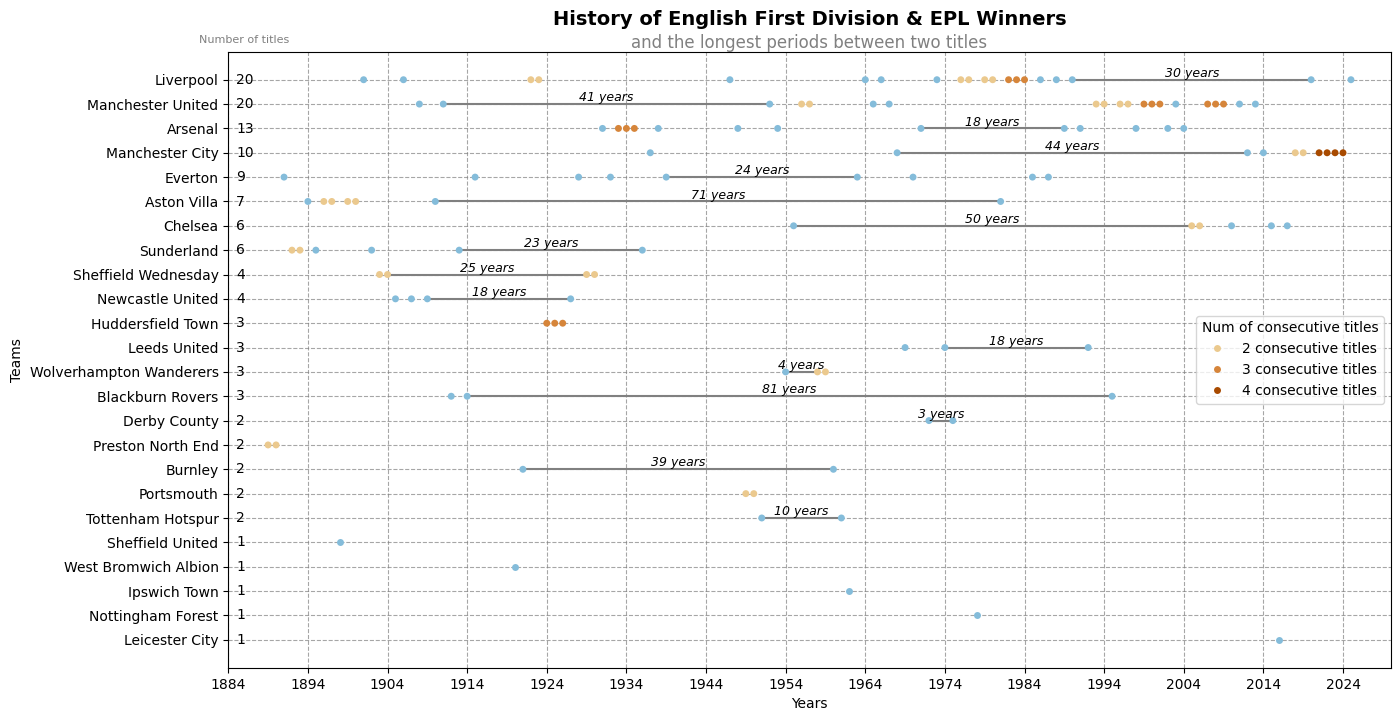

In [77]:
def history_of_title_winners(df):
    df = add_season_year(df)
    df = add_label_consecutive(df)
    titles_timeline(df)


history_of_title_winners(df)

# Laliga

In [78]:
laliga_html = pd.read_html('https://en.wikipedia.org/wiki/List_of_Spanish_football_champions')
laliga = laliga_html[2]
laliga


laliga.columns = [normalize_column_name(i) for i in laliga.columns]

# laliga = (
#     laliga
#     .rename({'champions_(number_of_titles)': 'champion'}, axis = 1)
#     .loc[:,['season', 'champion', 'runners_up', 'third_place']]
# )

# laliga = laliga[~ ((laliga['champion'].str.contains('War')) | (laliga['season'].str.contains(r'\('))) ]

# laliga = (
#     laliga
#     .assign(champion =              lambda df_: df_['champion'].str.extract(r'(^[\w\s]+)')[0].str.strip())
#     .assign(runners_up =            lambda df_: df_['runners_up'].str.extract(r'(^[\w\s]+)')[0].str.strip())
#     .assign(season_start =          lambda df_: df_.season.apply(lambda x: int(x[:4])))
#     .assign(season_end =            lambda df_: df_.season_start + 1)
#     .sort_values(by = ['champion', 'season_end'], ignore_index=True)
#     .assign(next_win =              lambda df_: df_.groupby('champion')['season_end'].shift(-1))
#     .assign(gap =                   lambda df_: df_['next_win'] - df_['season_end'])
#     .replace('The Wednesday', 'Sheffield Wednesday')
# )
laliga

,season,winners[3],pts,runners_up[6][7],pts.1,third_place[6][7],pts.2,top_scorer(s)[8],top_scorer's_club(s)[8],goals[8]
0,1929,Barcelona (1),25,Real Madrid (1),23,Athletic Bilbao (1),20,Paco Bienzobas,Real Sociedad,14
1,1929–30,Athletic Bilbao (1) †,30,Barcelona (1),23,Arenas (1),20,Guillermo Gorostiza,Athletic Bilbao,19
2,1930–31,Athletic Bilbao (2) †,22,Racing Santander (1),22,Real Sociedad (1),22,Bata,Athletic Bilbao,27
3,1931–32,Madrid FC[a] (1),28,Athletic Bilbao (1),25,Barcelona (1),24,Guillermo Gorostiza,Athletic Bilbao,12
4,1932–33,Madrid FC[a] (2),28,Athletic Bilbao (2),26,Espanyol (1),22,Manuel Olivares,Madrid FC,16
...,...,...,...,...,...,...,...,...,...,...
92,2020–21,Atlético Madrid (11),86,Real Madrid (24),84,Barcelona (13),79,Lionel Messi,Barcelona,30
93,2021–22,Real Madrid (35) †,86,Barcelona (27),73,Atlético Madrid (15),71,Karim Benzema,Real Madrid,27
94,2022–23,Barcelona (27),88,Real Madrid (25),78,Atlético Madrid (16),77,Robert Lewandowski,Barcelona,23
95,2023–24,Real Madrid (36) †,95,Barcelona (28),85,Girona (1),81,Artem Dovbyk,Girona,24


In [79]:
laliga

,season,winners[3],pts,runners_up[6][7],pts.1,third_place[6][7],pts.2,top_scorer(s)[8],top_scorer's_club(s)[8],goals[8]
0,1929,Barcelona (1),25,Real Madrid (1),23,Athletic Bilbao (1),20,Paco Bienzobas,Real Sociedad,14
1,1929–30,Athletic Bilbao (1) †,30,Barcelona (1),23,Arenas (1),20,Guillermo Gorostiza,Athletic Bilbao,19
2,1930–31,Athletic Bilbao (2) †,22,Racing Santander (1),22,Real Sociedad (1),22,Bata,Athletic Bilbao,27
3,1931–32,Madrid FC[a] (1),28,Athletic Bilbao (1),25,Barcelona (1),24,Guillermo Gorostiza,Athletic Bilbao,12
4,1932–33,Madrid FC[a] (2),28,Athletic Bilbao (2),26,Espanyol (1),22,Manuel Olivares,Madrid FC,16
...,...,...,...,...,...,...,...,...,...,...
92,2020–21,Atlético Madrid (11),86,Real Madrid (24),84,Barcelona (13),79,Lionel Messi,Barcelona,30
93,2021–22,Real Madrid (35) †,86,Barcelona (27),73,Atlético Madrid (15),71,Karim Benzema,Real Madrid,27
94,2022–23,Barcelona (27),88,Real Madrid (25),78,Atlético Madrid (16),77,Robert Lewandowski,Barcelona,23
95,2023–24,Real Madrid (36) †,95,Barcelona (28),85,Girona (1),81,Artem Dovbyk,Girona,24


In [80]:
laliga = (
    laliga
    .rename({'winners[3]': 'champion', 'runners_up[6][7]': 'runners_up', 'third_place[6][7]':'third_place' }, axis = 1)
    [['season','champion', 'runners_up', 'third_place']]
    .assign(champion        = lambda df_: df_['champion'].str.extract(r'([\w\s]*)')[0].str.strip())
    .assign(runners_up      = lambda df_: df_['runners_up'].str.extract(r'([\w\s]*)')[0].str.strip())
    .assign(third_place     = lambda df_: df_['third_place'].str.extract(r'([\w\s]*)')[0].str.strip())
    .replace('Madrid FC', 'Real Madrid')

)
laliga = laliga[~laliga['champion'].str.contains('War')]
laliga.loc[0, 'season'] = '1928-29'

laliga = (
    laliga
    .assign(season_start =          lambda df_: df_.season.apply(lambda x: int(x[:4])))
    .assign(season_end =            lambda df_: df_.season_start + 1)
    .sort_values(by = ['champion', 'season_end'], ignore_index=True)
    .assign(next_win =              lambda df_: df_.groupby('champion')['season_end'].shift(-1))
    .assign(gap =                   lambda df_: df_['next_win'] - df_['season_end'])
)


laliga

,season,champion,runners_up,third_place,season_start,season_end,next_win,gap
0,1929–30,Athletic Bilbao,Barcelona,Arenas,1929,1930,1931.0,1.0
1,1930–31,Athletic Bilbao,Racing Santander,Real Sociedad,1930,1931,1934.0,3.0
2,1933–34,Athletic Bilbao,Real Madrid,Racing Santander,1933,1934,1936.0,2.0
3,1935–36,Athletic Bilbao,Real Madrid,Oviedo,1935,1936,1943.0,7.0
4,1942–43,Athletic Bilbao,Sevilla,Barcelona,1942,1943,1956.0,13.0
...,...,...,...,...,...,...,...,...
89,1943–44,Valencia,Atlético Aviación,Sevilla,1943,1944,1947.0,3.0
90,1946–47,Valencia,Athletic Bilbao,Atlético Aviación,1946,1947,1971.0,24.0
91,1970–71,Valencia,Barcelona,Atlético Madrid,1970,1971,2002.0,31.0
92,2001–02,Valencia,Deportivo La Coruña,Real Madrid,2001,2002,2004.0,2.0


C:\Users\minhtl3\AppData\Local\Temp\ipykernel_16656\1305747927.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('champion', group_keys=False).apply(detect_label_consecutive).sort_values(by = 'season', ignore_index= True)


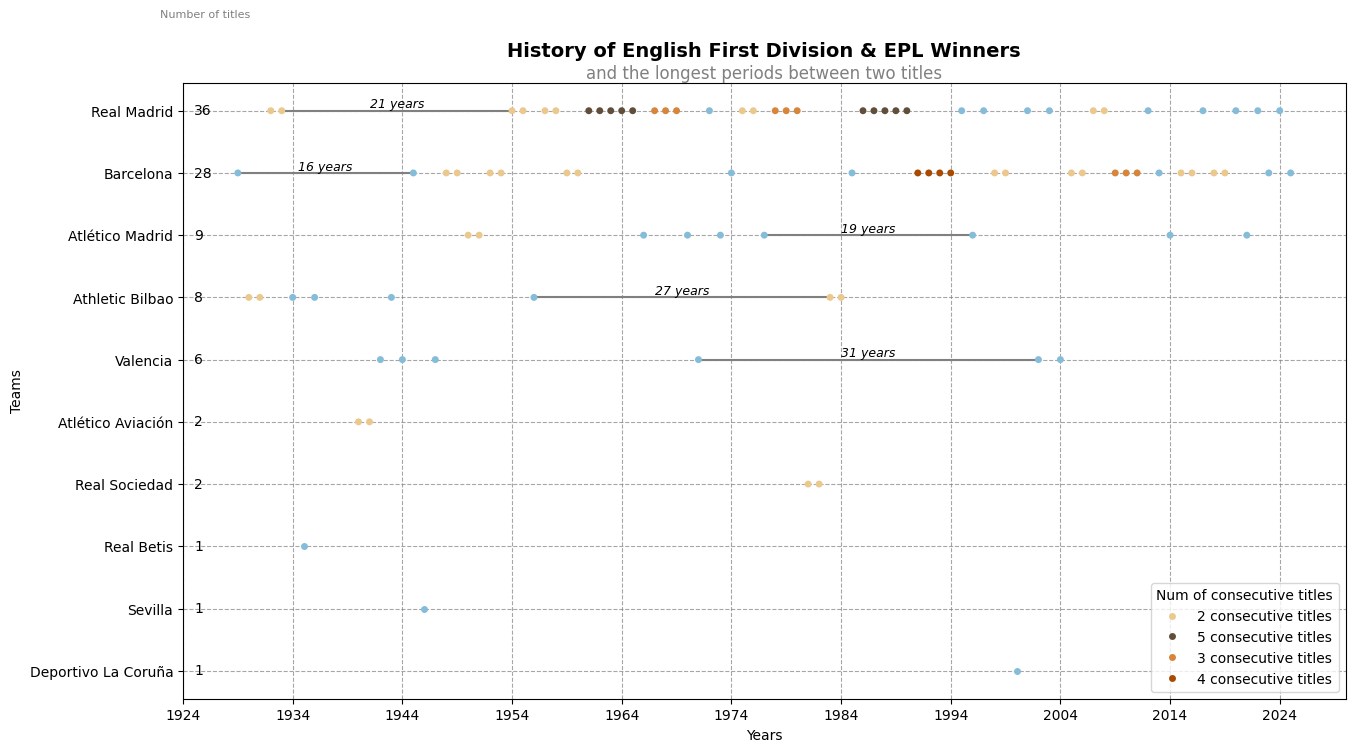

In [81]:
history_of_title_winners(laliga)